# [예제](https://docs.unsloth.ai/get-started/unsloth-notebooks)

## install

In [1]:
%%capture
import os

!python -m pip install --upgrade pip
!pip install typing_extensions==4.12.2
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm
# Install latest Hugging Face for Gemma-3!
!pip install --no-deps git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

In [2]:
# #@title Colab Extra Install { display-mode: "form" }
# %%capture
# import os
# if "COLAB_" not in "".join(os.environ.keys()):
#     !pip install unsloth vllm
# else:
#     !pip install --no-deps unsloth vllm
#     # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
#     # Skip restarting message in Colab
#     import sys, re, requests; modules = list(sys.modules.keys())
#     for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
#     !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
#     !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

#     # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
#     f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
#     with open("vllm_requirements.txt", "wb") as file:
#         file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
#     !pip install -r vllm_requirements.txt


## [Load Model](https://huggingface.co/unsloth)

In [3]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 16384, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-13 05:22:26 [__init__.py:239] Automatically detected platform cuda.
Unsloth: We'll be using `/tmp/unsloth_compiled_cache` for temporary Unsloth patches.
Standard import failed for UnslothBCOTrainer: No module named 'UnslothBCOTrainer'. Using tempfile instead!
==((====))==  Unsloth 2025.3.19: Fast Gemma3 patching. Transformers: 4.50.0.dev0. vLLM: 0.8.3.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.339 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

## PEFT : LoRA

In [4]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!
    r = 64,           # 0보다 큰 어떤 숫자도 선택 가능! 8, 16, 32, 64, 128이 권장됩니다.
    lora_alpha = 64,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",   # 바이어스를 지원합니다.
    random_state = 3407
)

Unsloth: Making `model.base_model.model.language_model.model` require gradients


## datasets

In [5]:
import glob
from datasets import load_dataset

csv_files = glob.glob("data/*.csv")    

# CSV 파일을 로드하는 코드입니다.
dataset = load_dataset("csv", data_files=csv_files, split="train")

# 데이터셋 확인
dataset

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['user_input', 'reference_contexts', 'reference'],
    num_rows: 1629
})

In [6]:
# EOS_TOKEN은 문장의 끝을 나타내는 토큰입니다. 이 토큰을 추가해야 합니다.
EOS_TOKEN = tokenizer.eos_token

# AlpacaPrompt를 사용하여 지시사항을 포맷팅하는 함수입니다.
alpaca_prompt = """
You are an expert AI chef.  
Based on the user's provided ingredients, cooking tools, and available time, search **only within the given recipe dataset** and recommend **exactly one** recipe that best matches the user's input.  
Respond **in Korean** and follow the format **exactly as shown below**. Do not include any additional explanations or extra content.

If a matching recipe is found, respond using the following format:
---
요리 이름: <Recipe Name>  
재료: <List of Ingredients>  
요리 시간: <Cooking Time>  
도구: <List of Tools>  
요리 방법:  
1. <Step 1>  
2. <Step 2>  
3. ...  
---

Here is an example output:
---
요리 이름: 계란 프라이  
재료: 계란, 식용유, 소금  
요리 시간: 5분  
도구: 프라이팬, 가스레인지  
요리 방법:  
1. 프라이팬에 식용유를 두르고 달굽니다.  
2. 계란을 깨뜨려 넣고 익힙니다.  
3. 소금을 뿌려 마무리합니다.  
---

### User Input:
{}

### Response:
{}
""" + EOS_TOKEN


# 주어진 예시들을 포맷팅하는 함수입니다.
def formatting_prompts_func(examples):
    questions = examples["user_input"]  # 질문을 가져옵니다.
    outputs = examples["reference"]    # 답변을 가져옵니다.
    texts = []  # 포맷팅된 텍스트를 저장할 리스트입니다.
    for question, output in zip(questions, outputs):
        # EOS_TOKEN을 추가해야 합니다. 그렇지 않으면 생성이 무한히 진행될 수 있습니다.
        text = alpaca_prompt.format(question, output)
        texts.append(text)
    return {
        "text": texts,  # 포맷팅된 텍스트를 반환합니다.
    }

# 데이터셋에 formatting_prompts_func 함수를 적용합니다. 배치 처리를 활성화합니다.
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)

Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['user_input', 'reference_contexts', 'reference', 'text'],
    num_rows: 1629
})

In [8]:
dataset[0]

{'user_input': '인사라타 라면의 조리 과정은 어떻게 되나요?',
 'reference_contexts': '["[세상에는 많은 왕들이 있다] [백종원의 김밥왕] [백종원의 카레왕] [백종원의 떡볶이왕] [백종원의 만두왕] [최고의 왕을 찾아라] [백종원의 라면 왕 / 왕 시리즈 1탄] [라면에 미 친자] 완성됐습니다 [누구든 도 전하라] [3인의 도전자] [이들의 운명을 거머쥔] 어떡해 라면 국물 탁해져요 [커플] 남겨는 주셔야 돼요? [오늘 처음 본 사이] [시민 심 사 위원 3명과] [또 한 사람] [음주 합리화] 참고로 나는 어 제 술도 마시고 왔어요 저 두 [라면 왕 호스트 / 어나 더 백(?)과 함께하는] 세 분 다, 세 분 다 박수 한 번 [막상막하의 대결] [라면 왕의 주인공은?] [지금 시작합니다] [백종원의 라면 왕] 천하제일 라면 왕을 뽑는 라면 대회 백종원의 라면 왕 그 첫 번째 대결을 시작하도록 하겠습니다 [전 K 사 아나운서]저는 전 아나 현 유튜브 새내기 진행을 맡은 조충현입니다, 반갑습니다 오로지 라면 맛으로 승부하기 위해서 라면을 끓이는 중에는 도전자들의 [블라인드 대결 진행] 얼굴, 목소리, 스펙 [심사위원에게] 그 어떤 것도 공개하지 않습니다 [결과 발표 후 얼굴 공개] 철저히 베일에 쌓여진 그런 상태입니다 [팀원 분들도 1화는 블라인드로 즐겨보세요] [미션 금액]오늘의 도 전 가격은 요 [빽라면 +1000원] 1,000원 입니다 (도전자들은) 라면과 물을 제외한 재료를 1,000원 이하로 사용 하셔야 합니다 [철저하게 진행한 재료값 검증] 대회 시작 전에 재료 값은 재료 값은 정말 검증을 [지금 시작합니다] 완벽하게, 철저하게 마친 상태입니다 [재료 검증 START] [첫 번째 라면 is 수란 라면] 계란 하나 [수란 라 면] [계란 266원] [대파 137원] 대파 34.4 [청양고추 195원] 청양고추 5g [마늘 6원]통마늘 2.3 이게 비쌀 텐데 고춧가루가 [고춧가루 31원] 0.5지 [후춧가루 0.6원] 

In [9]:
from trl import SFTTrainer, SFTConfig

tokenizer.padding_side = "right"  # 토크나이저의 패딩을 오른쪽으로 설정합니다.

# SFTTrainer를 사용하여 모델 학습 설정
trainer = SFTTrainer(
    model=model,  # 학습할 모델
    tokenizer=tokenizer,  # 토크나이저
    train_dataset=dataset,  # 학습 데이터셋
    eval_dataset=dataset,   # 테디노트에서 추가된 eval dataset
    dataset_text_field="text",  # 데이터셋에서 텍스트 필드의 이름
    dataset_num_proc=2,  # 데이터 처리에 사용할 프로세스 수
    packing=False,  # 짧은 시퀀스에 대한 학습 속도를 5배 빠르게 할 수 있음
    args=SFTConfig(
        max_seq_length=2048,  # 최대 시퀀스 길이
        per_device_train_batch_size=4,  # 각 디바이스당 훈련 배치 크기
        gradient_accumulation_steps=8,  # 그래디언트 누적 단계
        warmup_steps=100,  # 웜업 스텝 수
        num_train_epochs=50,  # 훈련 에폭 수
        max_steps=2000,  # 최대 스텝 수 # 공식문서에는 60
        logging_steps=10,  # logging 스텝 수
        learning_rate=2e-4,  # 학습률
        fp16=not torch.cuda.is_bf16_supported(),  # fp16 사용 여부, bf16이 지원되지 않는 경우에만 사용
        bf16=torch.cuda.is_bf16_supported(),  # bf16 사용 여부, bf16이 지원되는 경우에만 사용
        optim="adamw_8bit",  # 최적화 알고리즘
        weight_decay=0.01,  # 가중치 감소
        lr_scheduler_type="cosine",  # 학습률 스케줄러 유형 # 공식은 linear
        seed=123,  # 랜덤 시드 # 공식은 3407
        output_dir="outputs",  # 출력 디렉토리
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1629 [00:00<?, ? examples/s]

## Train

In [10]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A40. Max memory = 44.339 GB.
4.732 GB of memory reserved.


In [11]:
# @title Training model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,629 | Num Epochs = 40 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 119,209,984/4,000,000,000 (2.98% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.153100
20,1.231400
30,0.626500
40,0.466200
50,0.420600
60,0.391700
70,0.373000
80,0.372200
90,0.347500
100,0.362700


In [12]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

12405.8784 seconds used for training.
206.76 minutes used for training.
Peak reserved memory = 6.146 GB.
Peak reserved memory for training = 1.414 GB.
Peak reserved memory % of max memory = 13.861 %.
Peak reserved memory for training % of max memory = 3.189 %.


## Inference

In [13]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template="gemma-3",
)

# 질문들
questions = [
    "양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.",
    "닭고기와 감자, 그리고 30분의 시간이 있을 때, 오븐을 이용해서 만들 수 있는 요리 레시피를 알려주세요.",
    "고기와 채소를 사용하여 15분 안에 전자레인지로 만들 수 있는 간단한 요리를 추천해주세요.",
    "소고기, 감자, 그리고 40분의 시간이 있을 때, 후라이팬만 사용해서 만들 수 있는 요리를 추천해주세요."
]

# 답변들
answers = []

# 모델 추론을 위해 각 질문을 처리
for question in questions:
    # 추론 중 메시지 출력
    print("=" * 100)
    print("모델이 답변을 생성 중입니다...")
    print("\n")

    messages = [{
        "role": "user",
        "content": [{"type": "text", "text": question}]
    }]

    # 템플릿 적용
    text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,  # 모델 생성을 위한 프롬프트 추가
    )

    # 모델 추론
    output = model.generate(
        **tokenizer([text], return_tensors="pt").to("cuda"),
        max_new_tokens=1000,  # 출력 길이 증가
        temperature=1.0, top_p=0.95, top_k=64,
    )

    # 추론 완료 후 결과 출력
    # 텍스트 출력
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    answers.append(decoded_output)
    print("Response:")
    print(decoded_output)  # 텐서가 아닌 텍스트 출력
    print("=" * 100)

모델이 답변을 생성 중입니다...


Response:
user
양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.
model
양파, 마늘, 계란을 활용한 후라이팬 요리로 '마늘 토스트'가 적합합니다. 이 요리는 간단한 조리 과정으로, 마늘과 양파의 맛을 잘 섞어 튀긴 후, 계란과 노른자를 올려주면 완성됩니다. 마늘을 다질 때 수분이 들어가면 뻣뻣해지므로, 마지막에 잘라 노른자에 찍어 먹으면 좋습니다. 또한, 마늘의 향이 강하게 나지 않도록 조리할 수 있는 장점이 있습니다.
모델이 답변을 생성 중입니다...


Response:
user
닭고기와 감자, 그리고 30분의 시간이 있을 때, 오븐을 이용해서 만들 수 있는 요리 레시피를 알려주세요.
model
닭고기와 감자를 이용해서 오븐에서 요리를 할 때, 30분 정도의 조리 시간을 고려하면 다음과 같은 요리를 만들 수 있습니다.

**요리 이름:** 감자 계란 볶음밥

**재료:**

*   닭가슴살: 300g
*   감자: 2개 (중간 크기)
*   양파: 1개
*   계란: 3개
*   밥: 2공기
*   베이컨: 4줄
*   올리브유: 1Tbsp
*   소금: 적당히
*   후추: 적당히

**도구:**

*   전자레인지용 용기
*   가루 수분기
*   깔깔이

**요리 방법:**

1.  감자를 깨끗이 씻고 껍질을 벗긴 후, 적당한 크기로 썰어줍니다.
2.  팬에 올리브유를 두르고 감자를 볶습니다. 감자가 어느 정도 볶아지면, 양파를 추가하여 함께 볶습니다.
3.  그 다음 베이컨을 넣고 기름이 잘 빠지도록 볶습니다.
4.  감자와 양파가 볶아지면 불을 약하게 줄이고, 계란을 넣어 스크램블 하듯이 섞어줍니다.
5.  계란이 잘 익으면 밥을 추가하고 함께 볶아줍니다. 이때 감자, 양파, 베이컨과 잘 섞이도록 합니다.
6.  마지막으로 소금과 후추로 간을 맞추고, 원하는 경우 고추장을 추가하여 마무리합니다.

이 요리는 오븐을 사용하지 않고, 팬에서 직

## save model

### VLLM을 위한 float4 저장

In [14]:
base_model = "gemma3" # 병합을 수행할 베이스 모델
# huggingface_token = ""  # HuggingFace 토큰
# huggingface_repo = "Llama-3-Open-Ko-8B-Instruct-teddynote"  # 모델을 업로드할 repository
save_method = (
    "merged_4bit"  # "merged_4bit", "merged_4bit_forced", "merged_16bit", "lora"
)

In [15]:
model.save_pretrained_merged(
    base_model,
    tokenizer,
    save_method=save_method,  # 저장 방식을 16비트 병합으로 설정
)

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [00:24<00:24, 24.65s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:42<00:00, 21.06s/it]


### GGUF 변환

In [16]:
# Quantization 방식 설정
quantization_method = "q8_0"  # "f16" "q8_0" "q4_k_m" "q5_k_m"

In [17]:
model.save_pretrained_gguf(
    base_model, # 사전학습 모델이 저장될 폴더명
    quantization_type=quantization_method,
)

Unsloth: Updating system package directories
Unsloth: Install GGUF and other packages
Unsloth GGUF:hf-to-gguf:Loading model: gemma3
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2560, 262208}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:output_norm.weight,                torch.bfloat16 --> F32, shape = {2560}
Unsloth GGUF:hf-to-gguf:Set meta model
Unsloth GGUF:hf-to-gguf:Set model parameters
Unsloth GGUF:hf-to-gguf:Set model tokenizer
Unsloth GGUF:gguf.vocab:Setting special token type bos to 2
Unsloth GGUF:gguf.vocab:Setting special token type eos to 106
Unsloth GGUF:gguf.vocab:Setting sp

Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to gemma3.Q8_0.gguf with size = 4.1G
Unsloth: Successfully saved GGUF to:
gemma3.Q8_0.gguf


['gemma3.Q8_0.gguf']

In [ ]:
import os

os.environ["HF_TOKEN"] = ""

In [19]:
model.push_to_hub_gguf(
    base_model,
    quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
    repo_id = "INe904/gemma3-finetune-recipe2-gguf",
    # token = "hf_"
)

Unsloth GGUF:hf-to-gguf:Loading model: gemma3
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2560, 262208}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:output_norm.weight,                torch.bfloat16 --> F32, shape = {2560}
Unsloth GGUF:hf-to-gguf:Set meta model
Unsloth GGUF:hf-to-gguf:Set model parameters
Unsloth GGUF:hf-to-gguf:Set model tokenizer
Unsloth GGUF:gguf.vocab:Setting special token type bos to 2
Unsloth GGUF:gguf.vocab:Setting special token type eos to 106
Unsloth GGUF:gguf.vocab:Setting special token type unk to 3
Unsloth GGUF:gguf.vocab:Setting special token type pad to 0


Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to gemma3.Q8_0.gguf with size = 4.1G
Unsloth: Successfully saved GGUF to:
gemma3.Q8_0.gguf


No files have been modified since last commit. Skipping to prevent empty commit.


['gemma3.Q8_0.gguf']

In [20]:
#@title 수동 업로드
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj="./gemma3.Q8_0.gguf",
    path_in_repo="gemma3-finetune-recipe2.Q8_0.gguf",
    repo_id="INe904/gemma3-finetune-recipe2-gguf",
    repo_type="model",
    # token = "hf_"
)

  0%|          | 0/1 [00:00<?, ?it/s]

gemma3-finetune-recipe2.Q8_0.gguf:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/INe904/gemma3-finetune-recipe2-gguf/commit/1c4e310397629d7fbe90cd3700ac166b55040edc', commit_message='Upload gemma3-finetune-recipe2.Q8_0.gguf with huggingface_hub', commit_description='', oid='1c4e310397629d7fbe90cd3700ac166b55040edc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/INe904/gemma3-finetune-recipe2-gguf', endpoint='https://huggingface.co', repo_type='model', repo_id='INe904/gemma3-finetune-recipe2-gguf'), pr_revision=None, pr_num=None)

### [hugging face 확인](https://huggingface.co/good593/gemma3-finetune-gguf)

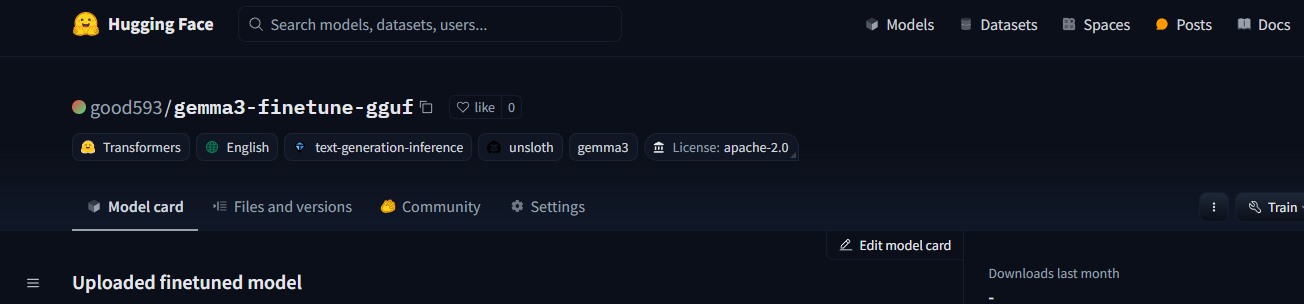